In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
from datetime import datetime
import pickle

In [3]:
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

# Predictive performance on regression and classification datasets

The predictive performance for regression and classification tasks is evaluated using the HS datasets. Similar to the experiment design used by (Abhineet et al. 2022) we evaluate the performance for each RF version for different degrees of model complexity. In our study we grow each random forest with a fixed number of trees d, for several choices of $d\in{15,\ 25,\ 50,\ 100}$. In contrast to the original experiment design, we do not incorporate ensembles with less than 15 trees as they do not yield OOB samples for all training observations and exclude ensembles with 200 trees due to the long computation time of our artifact. The predictive performance of each model is computed and averaged over 10 random splits of the test data.

## Run experiment

The code for the experiment is implemented in the script `Run_PredPerf_experiment`, so it can be run in the background and be parallelized. 
To rerun the experiment you have to copy the command and paste it into the terminal. After execution the scripts will run in the background and the results will be stored as pickle files under `data/pred_perf_experiment`.

In [ ]:
##Run experiment for all HS classification datasets and store results as pickle 
#nohup Run_PredPerf_experiment &

In [ ]:
##Run experiment for titanic dataset and store results as pickle 
#nohup Run_PredPerf_experiment --other_DS titanic &

In [ ]:
##Run experiment for all HS regression datasets and store results as pickle 
#nohup Run_PredPerf_experiment --DS_number 0 1 2 3 4 --model_type regression --scoring_func r2_score &

## Load results

In [4]:
# Get all files 
data_path = os.path.join(os.path.dirname(os.getcwd()),"data","pred_perf_experiment")
data_path_clf = os.path.join(data_path, "classification")
data_path_reg = os.path.join(data_path, "regression")

In [5]:
# Define order for datasets
dsets_name_clf = ["heart", "breast-cancer", "haberman", "diabetes", "german-credit"]
dsets_name_reg = ["friedman1", "friedman2", "friedman3", "abalone", "diabetes-regr"]

In [6]:
# Get path for all pickle files in classification folderws
pkl_clf = [None] * len(dsets_name_clf)
valid_type = [".pickle",".pkl"]

for f in os.listdir(data_path_clf):
    ext = os.path.splitext(f)[1]
    name = f.split("_")[0]
    if (ext.lower() not in valid_type) or (name=="titanic"):
        continue
    idx = dsets_name_clf.index(name)
    pkl_clf[idx] = os.path.join(data_path_clf,f)

In [7]:
# Get path for all pickle files in regression folderws
pkl_reg = [None] * len(dsets_name_reg)
valid_type = [".pickle",".pkl"]

for f in os.listdir(data_path_reg):
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_type:
        continue
    name = f.split("_")[0]
    idx = dsets_name_reg.index(name)
    pkl_reg[idx] = os.path.join(data_path_reg,f)

In [8]:
# Load clf pickle files
res_clf = {}
for name, i in zip(dsets_name_clf, pkl_clf):
    with open(i, "rb") as input_file:
        res_clf[name]=pickle.load(input_file)

In [ ]:
# Only needed because one result was not created by running the script but executing the command at the end of the notebook:
class pars:
    def __init__(self):
        self.DS_number = 2
        self.other_DS = None
        self.model_type = "regression"
        self.n_trees_list = [15,25,50,100]
        self.max_depth = None
        self.lambda_list = [0.1,1,10,25,50,100]
        self.cv = 3
        self.scoring_func = "r2_score"
        self.random_state = 42

In [12]:
# Load reg pickle files
res_reg = {}
for name, i in zip(dsets_name_reg, pkl_reg):
    with open(i, "rb") as input_file:
        res_reg[name]=pickle.load(input_file)

## Create plots

In [13]:
def create_perf_plot(res_exp, ax=None, show_legend=False, show_ylabel=True, show_xlabel=True):
    """Create performance comparison plot for one experiment"""
    
    if ax==None:
        fig, ax = plt.subplots(1,1, figsize=(7,5))
    
    model_names_gridcv = ['RF', 'HsRF', 'AugHS_smSHAP', 'AugHS_mse'] # for retrieving resultss from experiment
    dset_name = res_exp["data"]["dataset_name"]
    model_type = vars(res_exp["simulation_settings"])["model_type"]
    n_trees = vars(res_exp["simulation_settings"])["n_trees_list"]
    X = res_exp["data"]["X"]
    
    mu = []
    sem = []
    
    # Store mean and sem for each model 
    for i in model_names_gridcv:
        mu.append(res_exp[i]["scores"].mean(axis=1))
        sem.append(res_exp[i]["sem"])
    
    # Create plot
    ax.errorbar(x=n_trees, y=mu[0], yerr=sem[0], alpha=.5, linewidth=3, marker="o", label="RF")
    ax.errorbar(x=n_trees, y=mu[1], yerr=sem[1], alpha=.5, linewidth=3, marker="o", label="HsRF")
    ax.errorbar(x=n_trees, y=mu[2], yerr=sem[2], alpha=.5, linewidth=3, marker="o", label="AugHsRF smSHAP")
    ax.errorbar(x=n_trees, y=mu[3], yerr=sem[3], alpha=.5, linewidth=3, marker="o", label="AugHsRF MSE")        
    
    ax.set_title(f"{dset_name} (n = {X.shape[0]}, p = {X.shape[1]})")
    
    if show_xlabel:
        ax.set_xlabel("Number of Trees")
    
    if show_ylabel:
        y_label = "AUC" if model_type=="classification" else "R2"
        ax.set_ylabel(y_label)
    
    if show_legend:
        ax.legend()

### Classification

#### HS

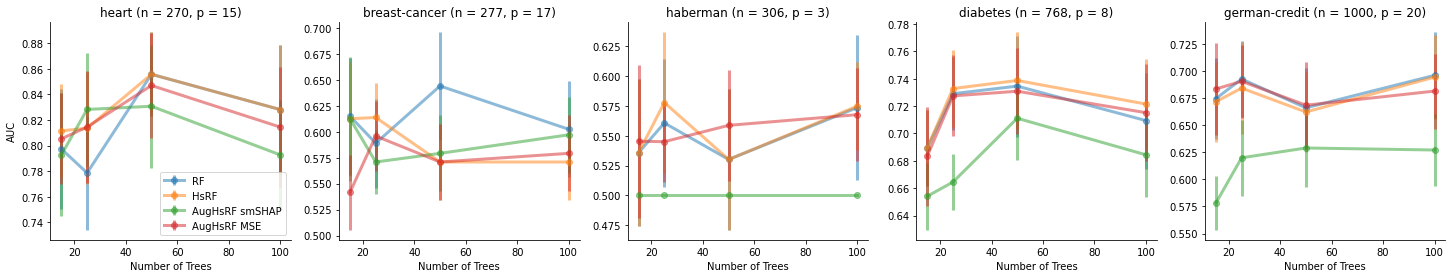

In [14]:
# Create plots classsification
model_names_gridcv = ['RF', 'HsRF', 'AugHS_smSHAP', 'AugHS_mse'] # for retrieving resultss from experiment

fig, axs = plt.subplots(1,5, figsize=(25,4))

for i, exp in enumerate(dsets_name_clf):
    if i == 0:
        create_perf_plot(res_clf[exp], axs[i], show_legend=True, show_ylabel=True) #show legend on first plot
        continue
    create_perf_plot(res_clf[exp], axs[i], show_legend=False, show_ylabel=False)

In [116]:
# Save figure
fig.savefig(f"{data_path_clf}/clf_plots.png")

#### Titanic

In [24]:
# Get all files 
data_path = os.path.join(os.path.dirname(os.getcwd()),"data","pred_perf_experiment")
data_path_clf = os.path.join(data_path, "classification")
dsets_name_titanic = ["titanic"]

# Get path for all pickle files in classification folderws
pkl_titanic = [None] * len(dsets_name_titanic)
valid_type = [".pickle",".pkl"]

for f in os.listdir(data_path_clf):
    ext = os.path.splitext(f)[1]
    name = f.split("_")[0]
    if (ext.lower() not in valid_type) or (name not in dsets_name_titanic):
        continue
    idx = dsets_name_titanic.index(name)
    pkl_titanic[idx] = os.path.join(data_path_clf,f)

# Load clf pickle files
with open(pkl_titanic[0], "rb") as input_file:
    res_titanic=pickle.load(input_file)

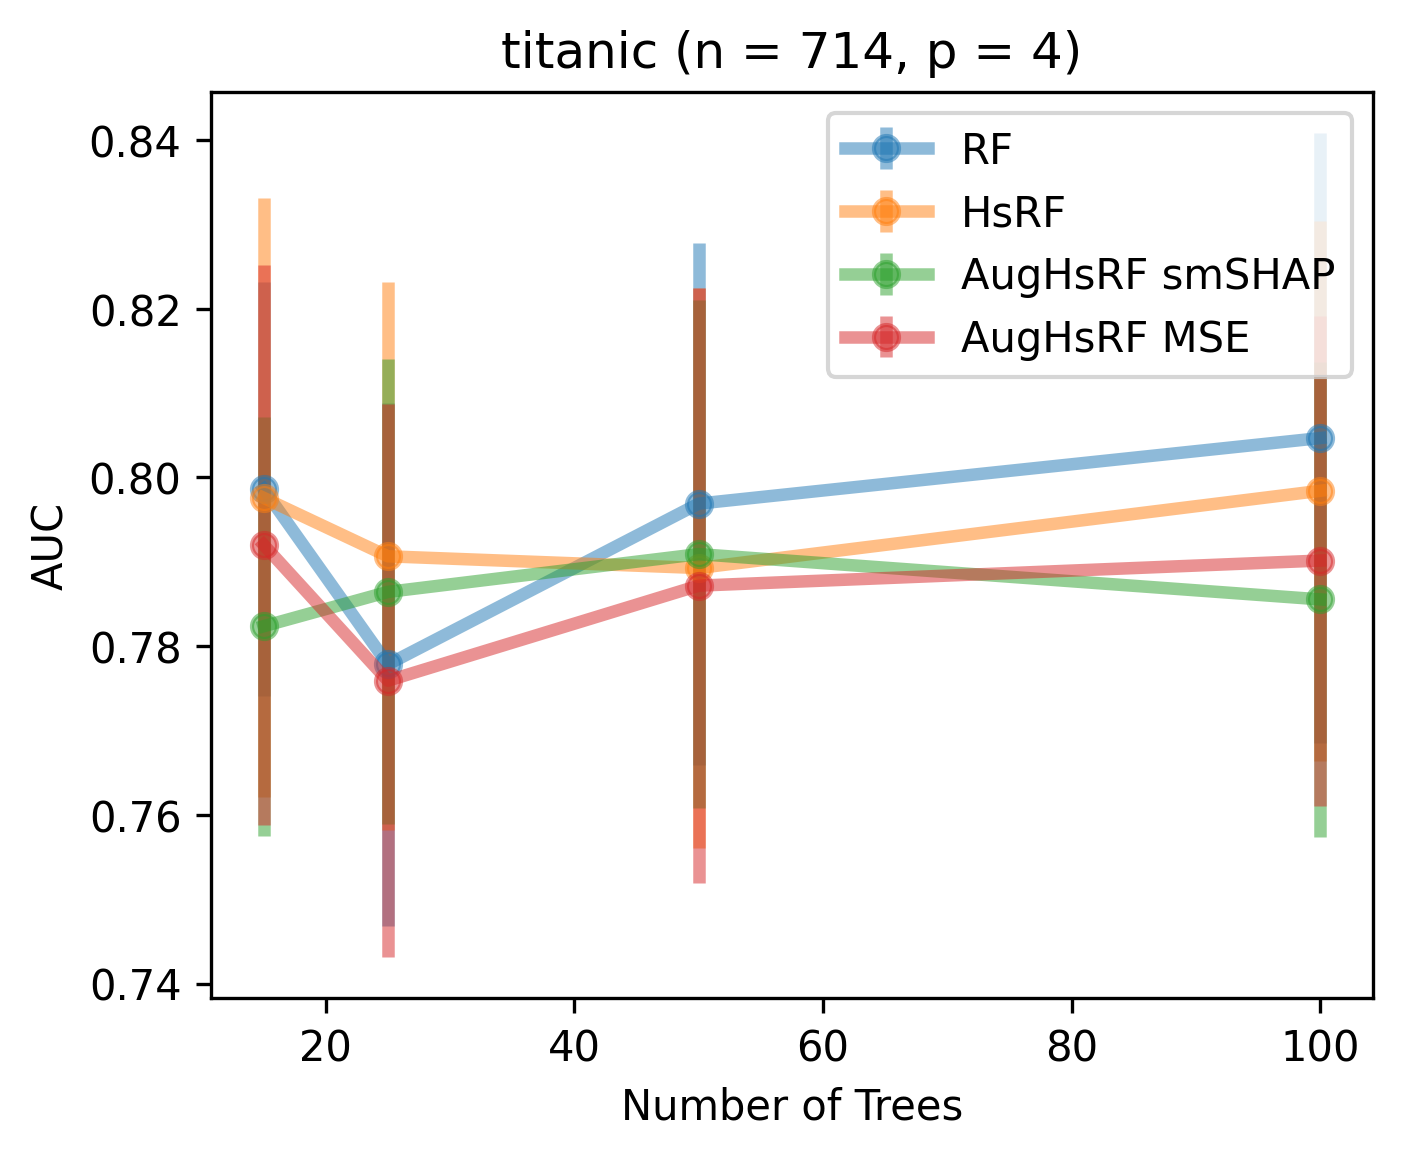

In [36]:
fig, axs = plt.subplots(1,1, figsize=(5,4))

create_perf_plot(res_titanic, axs, show_legend=True, show_ylabel=True) #show legend on first plot

#### Create Classification plot for thesis document

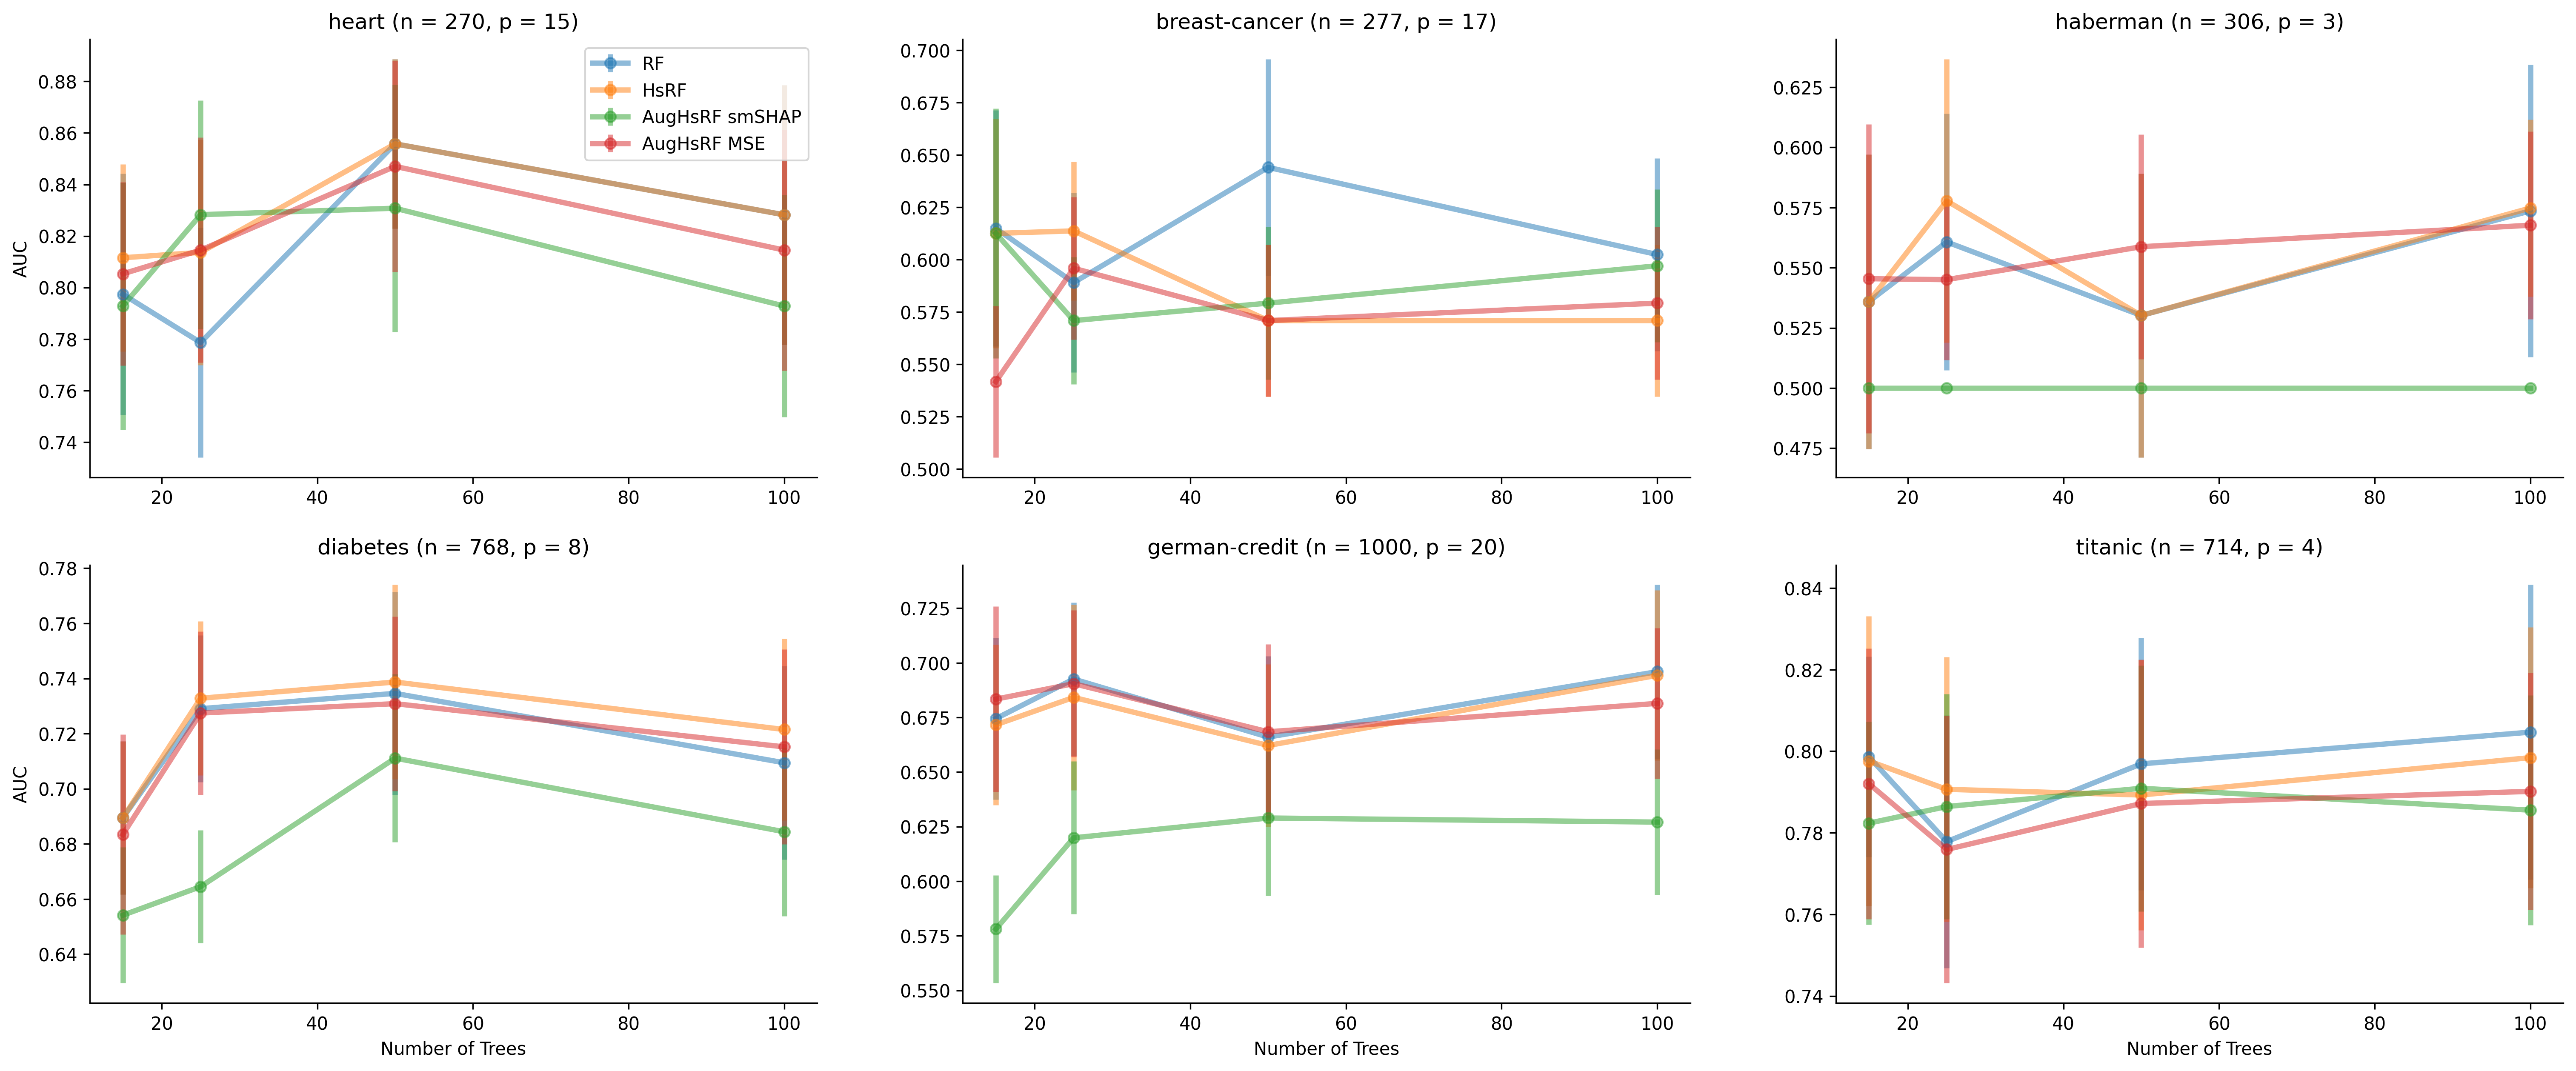

In [62]:
# Create plots classsification
model_names_gridcv = ['RF', 'HsRF', 'AugHS_smSHAP', 'AugHS_mse'] # for retrieving resultss from experiment

fig, axs2d = plt.subplots(2,3, figsize=(25,10), squeeze=False)
axs = axs2d.flatten()
dset_names = dsets_name_clf + ["titanic"]
res_clf["titanic"] = res_titanic
show_xlabel = [False, False, False, True, True, True]
show_ylabel = [True, False, False, True, False, False]

for i, exp in enumerate(dset_names):
    if (i == 0):
        create_perf_plot(res_clf[exp], axs[i], show_legend=True, show_ylabel=show_ylabel[i], show_xlabel=show_xlabel[i]) #show legend on first plot
        continue
    create_perf_plot(res_clf[exp], axs[i], show_legend=False, show_ylabel=show_ylabel[i], show_xlabel=show_xlabel[i])

In [63]:
# Save figure
fig.savefig(f"{data_path_clf}/clf_plots_all.png")

### Regression

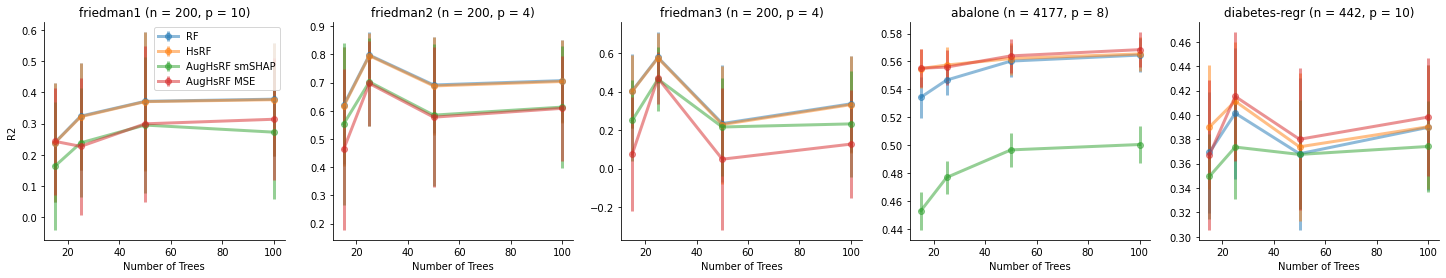

In [14]:
# Create plots regression
fig, axs = plt.subplots(1,5, figsize=(25,4))

for i, exp in enumerate(dsets_name_reg):
    if i == 0:
        create_perf_plot(res_reg[exp], axs[i], show_legend=True, show_ylabel=True) #show legend on first plot
        continue
    create_perf_plot(res_reg[exp], axs[i], show_legend=False, show_ylabel=False)

In [15]:
# Save figure
fig.savefig(f"{data_path_reg}/reg_plots.png")

#### Create Classification plot for thesis document

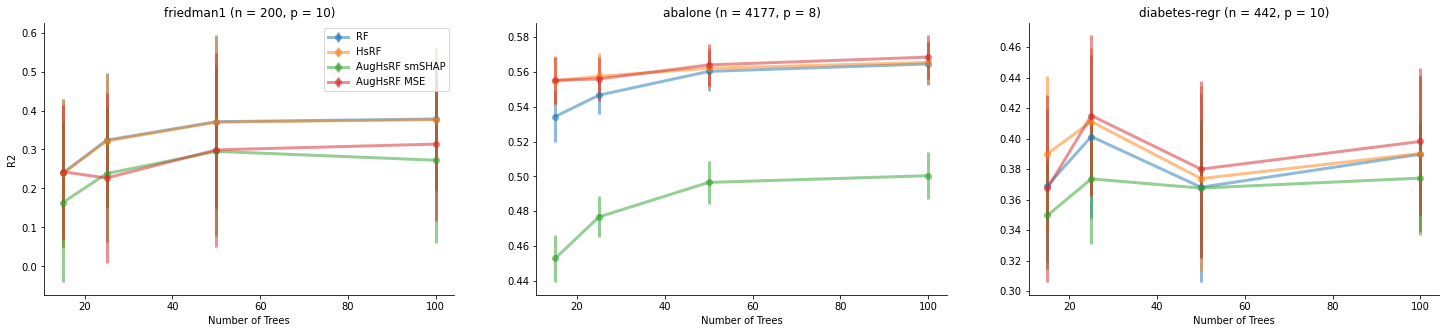

In [17]:
# Create plots classsification
fig, axs2d = plt.subplots(1,3, figsize=(25,5), squeeze=False)
axs = axs2d.flatten()
dset_names = ['friedman1', 'abalone', 'diabetes-regr']

for i, exp in enumerate(dset_names):
    if (i == 0):
        create_perf_plot(res_reg[exp], axs[i], show_legend=True, show_ylabel=True, show_xlabel=True) #show legend on first plot
        continue
    create_perf_plot(res_reg[exp], axs[i], show_legend=False, show_ylabel=False, show_xlabel=True)

In [18]:
# Save figure
fig.savefig(f"{data_path_reg}/reg_plots_small.png")

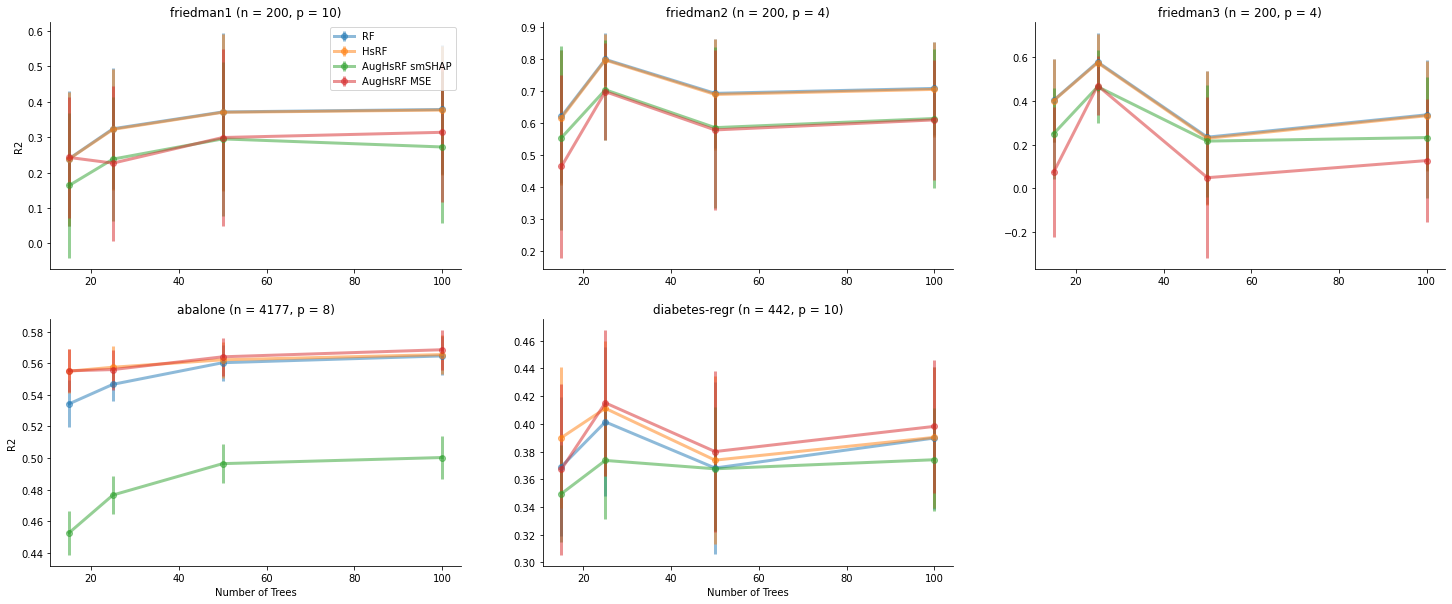

In [19]:
# Create plots classsification
fig, axs2d = plt.subplots(2,3, figsize=(25,10), squeeze=False)
axs = axs2d.flatten()
dset_names = res_reg.keys()
show_xlabel = [False, False, False, True, True, True]
show_ylabel = [True, False, False, True, False, False]

for i, exp in enumerate(dset_names):
    if (i == 0):
        create_perf_plot(res_reg[exp], axs[i], show_legend=True, show_ylabel=show_ylabel[i], show_xlabel=show_xlabel[i]) #show legend on first plot
        continue
    create_perf_plot(res_reg[exp], axs[i], show_legend=False, show_ylabel=show_ylabel[i], show_xlabel=show_xlabel[i])
    
axs[-1].set_visible(False)

In [20]:
# Save figure
fig.savefig(f"{data_path_reg}/reg_plots_big.png")

## Recreate script in notebook 

Check if error messages / warnings in nohup.out file also appear in notebook or just when running the experiment in the background

In [79]:
# Imports
import argparse
from sklearn.metrics import roc_auc_score, r2_score, accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from TreeModelsFromScratch.RandomForest import RandomForest
from TreeModelsFromScratch.SmoothShap import cross_val_score_scratch, GridSearchCV_scratch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from TreeModelsFromScratch.datasets import DATASETS_CLASSIFICATION, DATASETS_REGRESSION, DATASET_PATH
from imodels.util.data_util import get_clean_dataset
import os
from datetime import datetime
from multiprocessing import Pool
from itertools import repeat
from scipy.stats import sem


def run_single_experiment(X, y, model_type="classification", cv=3, scoring_func=roc_auc_score, n_trees = [15,25,50,100],
                          shuffle=True, random_state=None, lambda_list = [0.1,1,10,25,50,100]):
    '''Run predictive performance experiment for RF models (RF, HsRF, AugHsRF smSHAP, AugHsRF MSE) on HS datasets'''

    #Create random generator with random state
    random_gen = np.random.RandomState(random_state)
    MAX_INT = np.iinfo(np.int32).max
    seed_list = random_gen.randint(MAX_INT, size=5) # create 5 random seeds, one for the train test split, the others for the state of all the models for each iterration (so they are equal)

    # Split dataset into train-test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=seed_list[0])

    # Split test data into 10 random splits
    X_test_splits = np.array_split(X_test,10)
    y_test_splits = np.array_split(y_test,10)

    # Set mtry for classification to sqrt(m) and 1/3m for regression, where m is the number of features in the dataset
    if model_type=="classification":
        n_feature="sqrt"
    else:
        n_feature=1/3

    # Lists for storing results from GridSearch cross-validation
    cv_res_HsRF = []
    cv_res_AugHS_smSHAP = []
    cv_res_AugHS_MSE = []

    # Lists for storing best models per iteration
    RF_models=[]
    HsRF_models=[]
    AugHS_smSHAP_models=[]
    AugHS_mse_models=[]

    # Arrays for storing scoring results p. iterration and test set split
    scores_RF=np.full((len(n_trees), 10), np.nan)
    scores_HsRF=np.full((len(n_trees), 10), np.nan)
    scores_AugHS_smSHAP=np.full((len(n_trees), 10), np.nan)
    scores_AugHS_mse=np.full((len(n_trees), 10), np.nan)

    # Iterate over each number of trees
    for i, n_tree in enumerate(tqdm(n_trees)):

        # RF model without regularization
        rf = RandomForest(n_trees=n_tree, treetype=model_type, random_state=seed_list[i+1],
                                  n_feature=n_feature, oob=False)
        rf.fit(X_train, y_train)
        RF_models.append(rf)
        print("RF model trained")

        #HsRF
        grid = {"HS_lambda":lambda_list}
        HsRF = RandomForest(n_trees=n_tree, treetype=model_type, n_feature=n_feature,
                                    HShrinkage=True, random_state=seed_list[i+1], oob=False)
        grid_result_ = GridSearchCV_scratch(HsRF, grid, X_train, y_train, cv=cv, scoring_func=scoring_func,
                                                 shuffle=shuffle, random_state=seed_list[0])
        grid_result_["HS_lambda"] = HsRF.HS_lambda
        cv_res_HsRF.append(grid_result_)
        HsRF_models.append(HsRF)
        print("hsRF model trained")

        # AugHS smSHAP
        AugHS_smSHAP = RandomForest(n_trees=n_tree, treetype=model_type, n_feature=n_feature,
                                    HShrinkage=False, random_state=seed_list[i+1], oob=True,
                                    oob_SHAP=True, HS_smSHAP=True)
        grid_result_ = GridSearchCV_scratch(AugHS_smSHAP, grid, X_train, y_train, cv=cv, scoring_func=scoring_func,
                                                 shuffle=shuffle, random_state=seed_list[0])
        grid_result_["smSHAP_coefs"] = AugHS_smSHAP.smSHAP_coefs
        grid_result_["HS_lambda"] = AugHS_smSHAP.HS_lambda
        cv_res_AugHS_smSHAP.append(grid_result_)
        AugHS_smSHAP_models.append(AugHS_smSHAP)
        print("AugHsRF smSHAP model trained")

        # AugHS MSE
        AugHS_mse = RandomForest(n_trees=n_tree, treetype=model_type, n_feature=n_feature,
                                    HShrinkage=False, random_state=seed_list[i+1], oob=True,
                                    HS_nodewise_shrink_type="MSE_ratio")
        grid_result_ = GridSearchCV_scratch(AugHS_mse, grid, X_train, y_train, cv=cv, scoring_func=scoring_func,
                                                 shuffle=shuffle, random_state=seed_list[0])
        grid_result_["HS_lambda"] = AugHS_mse.HS_lambda
        cv_res_AugHS_MSE.append(grid_result_)
        AugHS_mse_models.append(AugHS_mse)
        print("AugHsRF MSE model trained")

        # Get scores for each model for all splits
        for j, (X_test_split, y_test_split) in enumerate(zip(X_test_splits, y_test_splits)):
            scores_RF[i,j] = scoring_func(y_test_split, rf.predict(X_test_split))
            scores_HsRF[i,j] = scoring_func(y_test_split, HsRF.predict(X_test_split))
            scores_AugHS_smSHAP[i,j] = scoring_func(y_test_split, AugHS_smSHAP.predict(X_test_split))
            scores_AugHS_mse[i,j] = scoring_func(y_test_split, AugHS_mse.predict(X_test_split))
        print("Predictions completed")

    # Calculate SEM
    sem_RF = sem(scores_RF, axis=1)
    sem_HsRF = sem(scores_HsRF, axis=1)
    sem_AugHS_smSHAP = sem(scores_AugHS_smSHAP, axis=1)
    sem_AugHS_mse = sem(scores_AugHS_mse, axis=1)

    # Store experiment results in dictonary
    data = {
        "data":
            {
                "X": X,
                "y": y,
                "X_train": X_train,
                "X_test": X_test,
                "y_train": y_train,
                "y_test": y_test,
                "X_test_splits": X_test_splits,
                "y_test_splits": y_test_splits,
                "random_gen": random_gen,
                "seed_list": seed_list
            },
        "RF":
            {
                "models": RF_models,
                "sem": sem_RF,
                "scores": scores_RF
            },
        "HsRF":
            {
                "models": HsRF_models,
                "sem": sem_HsRF,
                "scores": scores_HsRF,
                "grid_cv_results":cv_res_HsRF
            },
        "AugHS_smSHAP":
            {
                "models": AugHS_smSHAP_models,
                "sem": sem_AugHS_smSHAP,
                "scores": scores_AugHS_smSHAP,
                "grid_cv_results":cv_res_AugHS_smSHAP
            },
        "AugHS_mse":
            {
                "models": AugHS_mse_models,
                "sem": sem_AugHS_mse,
                "scores": scores_AugHS_mse,
                "grid_cv_results":cv_res_AugHS_MSE
            }
        }

    return data


def run_performance_comparison(DS_number, opt, data_path):

    #Load HS datasets
    if (opt.model_type =="classification") & (opt.other_DS==None):
        dset_name, dset_file, data_source = DATASETS_CLASSIFICATION[DS_number]
        X, y, feat_names = get_clean_dataset(dset_file, data_source, DATASET_PATH)
    elif (opt.model_type =="regression") & (opt.other_DS==None):
        dset_name, dset_file, data_source = DATASETS_REGRESSION[DS_number]
        X, y, feat_names = get_clean_dataset(dset_file, data_source, DATASET_PATH)

    # Load datasets which are not included in original HS paper
    elif opt.other_DS!=None:
        dset_name = opt.other_DS
        # Load and clean titanic
        if dset_name=="titanic":
            dset_file = os.path.join(os.path.dirname(os.getcwd()),"raw_data","titanic", "titanic_train.csv")
            data = pd.read_csv(dset_file)
            data = data[data["Age"].notnull()] #filter rows which are nan
            data["Sex (Female)"] = pd.get_dummies(data["Sex"])["female"] #dummy code sex (1==Female)
            X = data[['Age', 'Pclass', 'Sex (Female)', 'PassengerId']]
            y = data["Survived"].astype("float")
            feat_names = X.columns.tolist()

    print(f"{dset_name} loaded")

    # Load scoring function
    scoring_func_dict = {
        "roc_auc_score": roc_auc_score,
        "r2_score": r2_score,
        "accuracy_score": accuracy_score}

    # Run performance test
    data = run_single_experiment(X, y, model_type=opt.model_type, cv=opt.cv, scoring_func=scoring_func_dict.get(opt.scoring_func),
                                 n_trees = opt.n_trees_list, shuffle=True, random_state=opt.random_state, lambda_list=opt.lambda_list)

    # Add simulation parameters to result dict
    data["data"]["dataset_name"]= dset_name
    data["data"]["feat_names"]= feat_names
    data["simulation_settings"]= opt
    
    # # Store results as pickle file
    # with open(f"{data_path}/{dset_name}_experiment_results.pickle", 'wb') as handle:
    #     pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # print(f"Data stored under : {data_path}/{dset_name}_experiment_results.pickle")
    
    return data


In [11]:
class pars:
    def __init__(self):
        self.DS_number = 2
        self.other_DS = None
        self.model_type = "regression"
        self.n_trees_list = [15,25,50,100]
        self.max_depth = None
        self.lambda_list = [0.1,1,10,25,50,100]
        self.cv = 3
        self.scoring_func = "r2_score"
        self.random_state = 42


In [81]:
opt = pars()

# for storing results
data_path = data_path_reg

# Parallelize script for all given datasets
data = run_performance_comparison(opt.DS_number, opt, data_path)

friedman3 loaded


  0%|          | 0/4 [00:00<?, ?it/s]

RF model trained
hsRF model trained
AugHsRF smSHAP model trained


 25%|██▌       | 1/4 [02:02<06:06, 122.04s/it]

AugHsRF MSE model trained
Predictions completed
RF model trained
hsRF model trained
AugHsRF smSHAP model trained


 50%|█████     | 2/4 [05:19<05:32, 166.18s/it]

AugHsRF MSE model trained
Predictions completed
RF model trained
hsRF model trained
AugHsRF smSHAP model trained


 75%|███████▌  | 3/4 [11:55<04:31, 271.11s/it]

AugHsRF MSE model trained
Predictions completed
RF model trained
hsRF model trained
AugHsRF smSHAP model trained
AugHsRF MSE model trained


100%|██████████| 4/4 [25:03<00:00, 375.78s/it]

Predictions completed


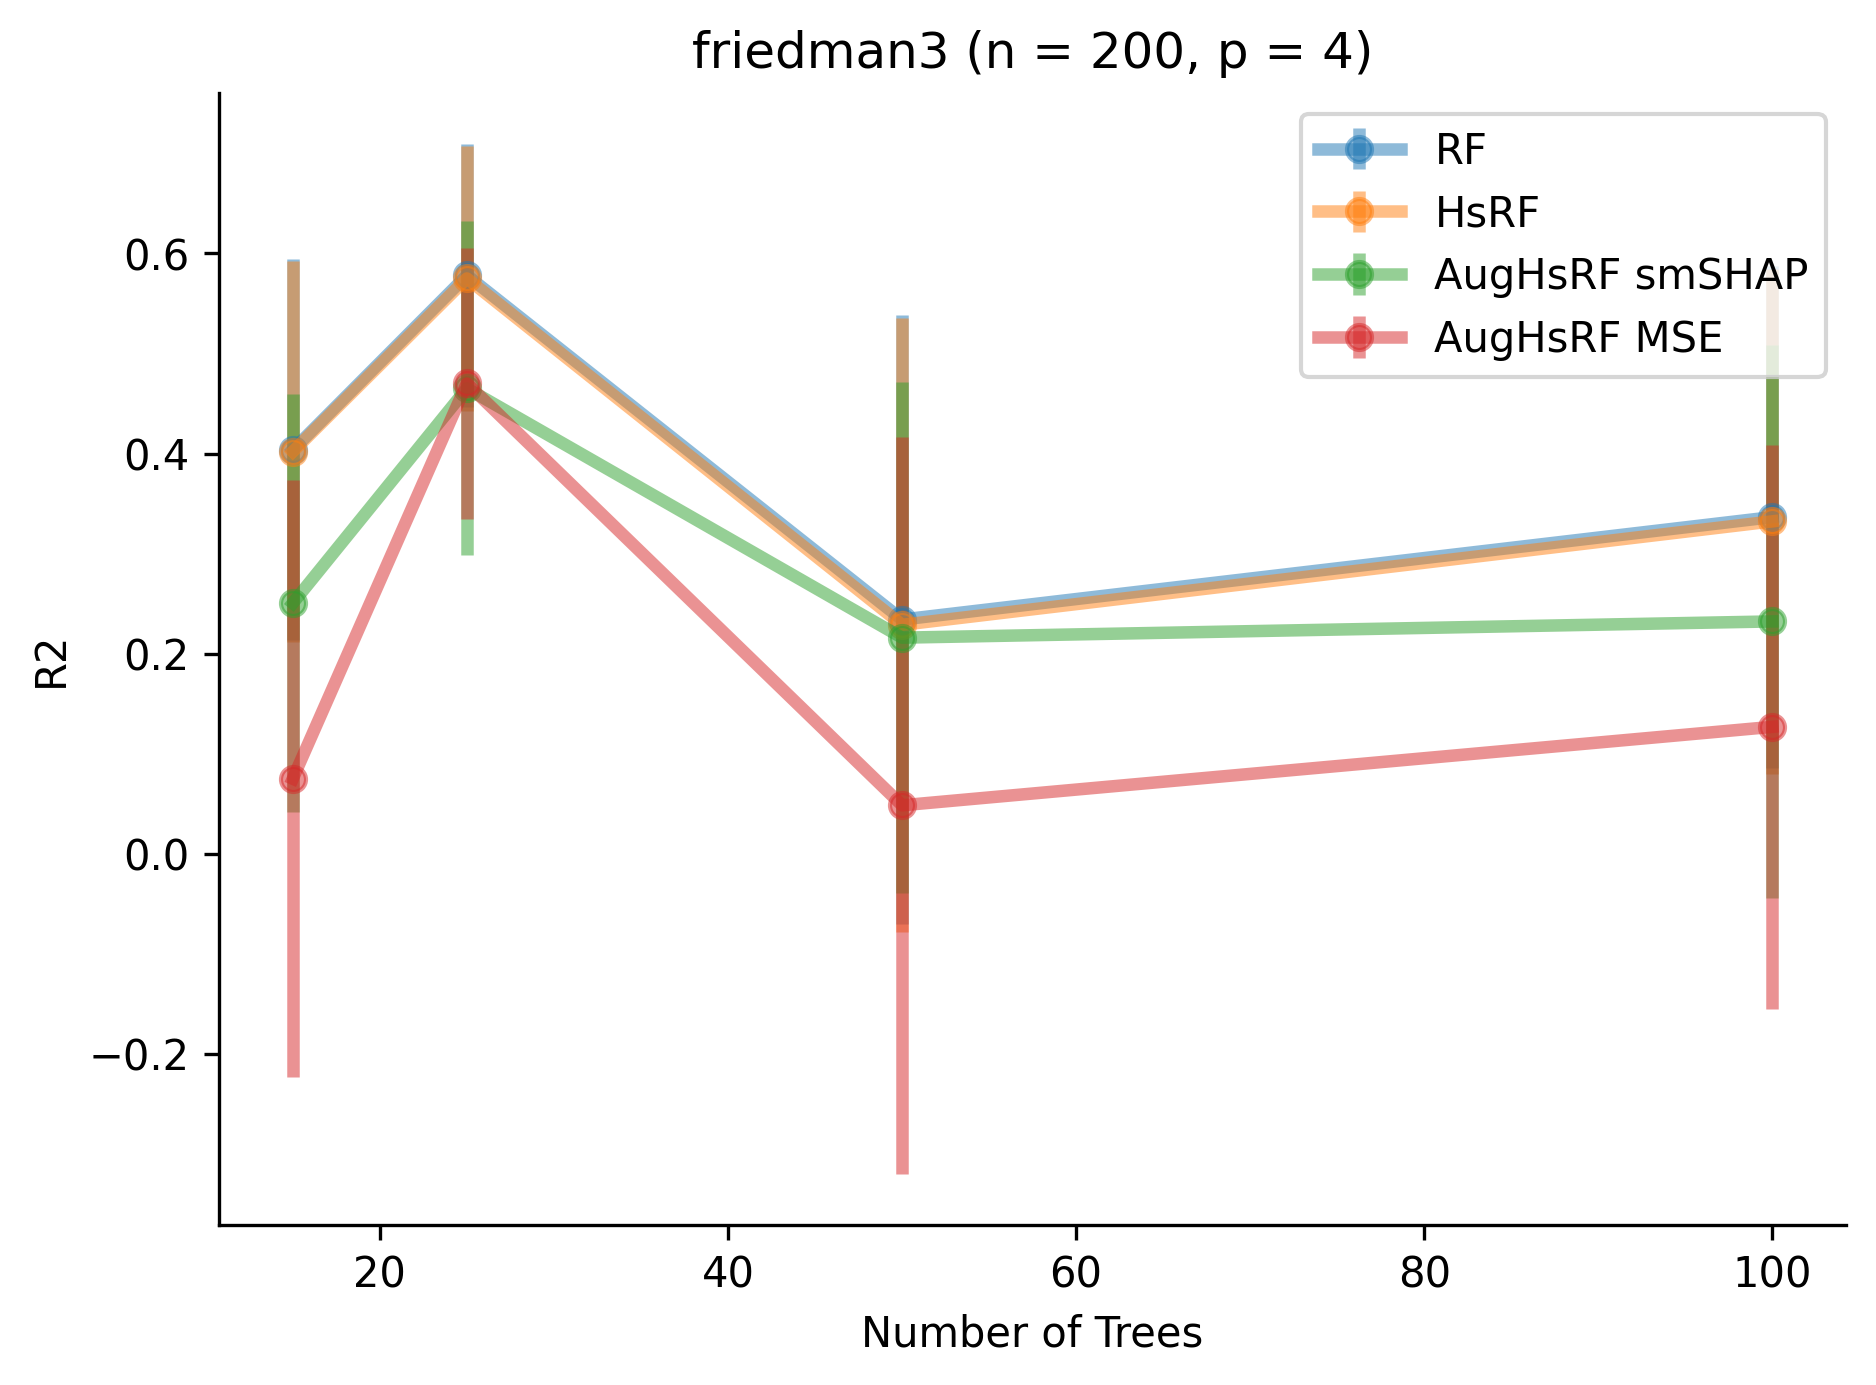

In [84]:
create_perf_plot(data, ax=None, show_legend=True, show_ylabel=True, show_xlabel=True)

In [85]:
# Store results as pickle file
dset_name ="friedman3"
with open(f"{data_path_reg}/{dset_name}_experiment_results.pickle", 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Data stored under : {data_path_reg}/{dset_name}_experiment_results.pickle")

Data stored under : /home/philipp_heitmann/SelectiveHierarchicalShrinkage/data/pred_perf_experiment/regression/friedman3_experiment_results.pickle


It seems that the error messages only appear when u run the script in the background